# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic

In [3]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [4]:
from datasets import GtsrbModule

In [5]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.datamodules import STL10DataModule

In [6]:
from models import ResnetModule

In [7]:
from dropblock import DropBlock2D, LinearScheduler

In [8]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier
from ls_ood_detect_cea.metrics import get_ood_detector_results, plot_roc_ood_detector

# Datasets

## GTSRB-Normal

In [9]:
dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"

In [10]:
gtsrb_normal_dm = GtsrbModule(data_path=dataset_path, batch_size=1, shuffle=True)

In [11]:
gtsrb_normal_dm.setup(stage='fit')
gtsrb_normal_dm.setup(stage='validate')
gtsrb_normal_dm.setup(stage='test')
print(gtsrb_normal_dm.ds_gtsrb_train)
print(gtsrb_normal_dm.ds_gtsrb_valid)
print(gtsrb_normal_dm.ds_gtsrb_test)

Dataset ImageFolder
    Number of datapoints: 35600
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/train_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fc389693d10>
Dataset ImageFolder
    Number of datapoints: 3609
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/val_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fc431e93e90>
Dataset ImageFolder
    Number of datapoints: 1273
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/test_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fc389960ed0>


In [12]:
gtsrb_normal_train_loader = gtsrb_normal_dm.train_dataloader()
gtsrb_normal_valid_loader = gtsrb_normal_dm.val_dataloader()
gtsrb_normal_test_loader = gtsrb_normal_dm.test_dataloader()
ic(len(gtsrb_normal_train_loader));
ic(len(gtsrb_normal_valid_loader));
ic(len(gtsrb_normal_test_loader));

ic| len(gtsrb_normal_train_loader): 35600
ic| len(gtsrb_normal_valid_loader): 3609
ic| len(gtsrb_normal_test_loader): 1273


In [68]:
dataiter = iter(gtsrb_normal_train_loader)

Dangerous curve to the left


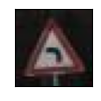

In [84]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_normal_dm.idx2label[lbl_np.item()])
gtsrb_normal_dm.unprocess_image(samp[0], plot=True)

## GTSRB-Anomalies

In [69]:
dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"

In [85]:
gtsrb_anomal_dm = GtsrbModule(data_path=dataset_path, batch_size=1, anomaly_transforms=True)

In [86]:
gtsrb_anomal_dm.setup(stage='fit')
gtsrb_anomal_dm.setup(stage='validate')
gtsrb_anomal_dm.setup(stage='test')
print(gtsrb_anomal_dm.ds_gtsrb_train)
print(gtsrb_anomal_dm.ds_gtsrb_valid)
print(gtsrb_anomal_dm.ds_gtsrb_test)

Dataset ImageFolder
    Number of datapoints: 35600
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/train_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fc3801d5350>
Dataset ImageFolder
    Number of datapoints: 3609
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/val_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fc33c4ba150>
Dataset ImageFolder
    Number of datapoints: 1273
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/test_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fc33c546710>


In [87]:
gtsrb_anomal_train_loader = gtsrb_anomal_dm.train_dataloader()
gtsrb_anomal_valid_loader = gtsrb_anomal_dm.val_dataloader()
gtsrb_anomal_test_loader = gtsrb_anomal_dm.test_dataloader()
ic(len(gtsrb_anomal_train_loader));
ic(len(gtsrb_anomal_valid_loader));
ic(len(gtsrb_anomal_test_loader));

ic| len(gtsrb_anomal_train_loader): 35600
ic| len(gtsrb_anomal_valid_loader): 3609
ic| len(gtsrb_anomal_test_loader): 1273


In [88]:
dataiter = iter(gtsrb_anomal_train_loader)

Speed limit (20km/h)


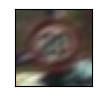

In [188]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_normal_dm.idx2label[lbl_np.item()])
gtsrb_normal_dm.unprocess_image(samp[0], plot=True)

In [129]:
samp.shape

torch.Size([1, 3, 32, 32])

## CIFAR-10 OoD

In [239]:
cifar10_data_dir = "/media/farnez/Data/DATASETS/cifar-10/"

In [240]:
cifar10_dm = CIFAR10DataModule(data_dir=cifar10_data_dir,
                               val_split=0.2,
                               num_workers=10,
                               normalize=True,
                               batch_size=1,
                               seed=10,
                               drop_last=True,
                               shuffle=True)

cifar10_transforms = transform_lib.Compose([
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
        std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
    )
])

cifar10_dm.train_transforms = cifar10_transforms
cifar10_dm.test_transforms = cifar10_transforms
cifar10_dm.val_transforms  = cifar10_transforms

In [241]:
cifar10_dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified


In [242]:
cifar10_dm.setup(stage='fit')
cifar10_dm.setup(stage='test')

In [243]:
cifar10_train_loader = cifar10_dm.train_dataloader()
cifar10_valid_loader = cifar10_dm.val_dataloader()
cifar10_test_loader = cifar10_dm.test_dataloader()
ic(len(cifar10_train_loader));
ic(len(cifar10_valid_loader));
ic(len(cifar10_test_loader));

ic| len(cifar10_train_loader): 40000
ic| len(cifar10_valid_loader): 10000
ic| len(cifar10_test_loader): 10000


In [244]:
def unprocess_cifar10_image(im,
                            norm_mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                            norm_std=[x / 255.0 for x in [63.0, 62.1, 66.7]], 
                            plot=False):
    # im = im.squeeze().numpy().transpose((1, 2, 0))
    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [245]:
dataiter = iter(cifar10_train_loader)

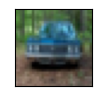

In [251]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_cifar10_image(samp[0], plot=True)

In [252]:
samp.shape

torch.Size([1, 3, 32, 32])

## STL-10 OoD

In [253]:
stl10_data_dir = "/media/farnez/Data/DATASETS/stl-10/"

In [254]:
stl10_dm = STL10DataModule(data_dir=stl10_data_dir,
                           train_val_split=1000,
                           num_workers=10,
                           batch_size=1,
                           seed=10,
                           drop_last=True,
                           shuffle=True)

stl10_transforms = transform_lib.Compose([
    transform_lib.Resize((32, 32)),
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=(0.43, 0.42, 0.39),
        std=(0.27, 0.26, 0.27)
    )
])

stl10_dm.train_transforms = stl10_transforms
stl10_dm.test_transforms = stl10_transforms
stl10_dm.val_transforms  = stl10_transforms

In [255]:
stl10_dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [256]:
stl10_train_loader = stl10_dm.train_dataloader_labeled()
stl10_valid_loader = stl10_dm.val_dataloader_labeled()
stl10_test_loader = stl10_dm.test_dataloader()
ic(len(stl10_train_loader));
ic(len(stl10_valid_loader));
ic(len(stl10_test_loader));

ic| len(stl10_train_loader): 4000
ic| len(stl10_valid_loader): 1000
ic| len(stl10_test_loader): 8000


In [257]:
def unprocess_stl10_image(im,
                          norm_mean=[0.43, 0.42, 0.39],
                          norm_std=[0.27, 0.26, 0.27], 
                          plot=False):
    # im = im.squeeze().numpy().transpose((1, 2, 0))
    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [258]:
dataiter = iter(stl10_train_loader)

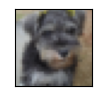

In [259]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_stl10_image(samp[0], plot=True)

# GTSRB ResNet18 Classifier

In [193]:
gtsrb_model_path = "/home/farnez/Projects/GTSRB-Classifier/lightning_logs/2023-05-10_11-01-59/epoch=1007-step=141120.ckpt"
gtsrb_model = ResnetModule.load_from_checkpoint(checkpoint_path=gtsrb_model_path)

In [194]:
gtsrb_model

ResnetModule(
  (loss_fn): FocalLoss()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum

In [195]:
gtsrb_model.eval();

# Add Hook

We add 2 Hooks:

1. In the dropblock2d layer (after applying dropout to the)
2. In the fc (after applying a linear transformation to the output of the dropblock2d layer)

In [196]:
ic(gtsrb_model.model.dropblock2d_layer);
ic(gtsrb_model.model.dropblock2d_layer.drop_prob);
ic(gtsrb_model.model.dropblock2d_layer.training);

ic| gtsrb_model.model.dropblock2d_layer: DropBlock2D()
ic| gtsrb_model.model.dropblock2d_layer.drop_prob: 0.3
ic| gtsrb_model.model.dropblock2d_layer.training: False


In [197]:
ic(gtsrb_model.model.dropout_layer);
ic(gtsrb_model.model.dropout_layer.p);
ic(gtsrb_model.model.dropout_layer.training);

ic| gtsrb_model.model.dropout_layer: Dropout(p=0.3, inplace=False)
ic| gtsrb_model.model.dropout_layer.p: 0.3
ic| gtsrb_model.model.dropout_layer.training: False


In [198]:
ic(gtsrb_model.model.fc);

ic| gtsrb_model.model.fc: Linear(in_features=512, out_features=43, bias=True)


## Hook DropBlock2D Layer

In [199]:
gtsrb_model_dropblock2d_layer_hook = Hook(gtsrb_model.model.dropblock2d_layer)

## Hook FC Layer

In [200]:
gtsrb_model_fc_layer_hook = Hook(gtsrb_model.model.fc)

# Get Monte-Carlo Samples

In [220]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [221]:
# Monte Carlo Dropout - Enable Dropout @ Test Time!
def resnet18_enable_dropblock2d_test(m):
    if type(m) == DropBlock2D:
        m.train()

In [222]:
mc_samples = 32

In [223]:
gtsrb_model.to(device);
gtsrb_model.eval(); 
gtsrb_model.apply(resnet18_enable_dropblock2d_test); # enable dropout

In [224]:
ic(gtsrb_model.model.dropblock2d_layer);
ic(gtsrb_model.model.dropblock2d_layer.drop_prob);
ic(gtsrb_model.model.dropblock2d_layer.training);
ic("=======")
ic(gtsrb_model.model.dropout_layer);
ic(gtsrb_model.model.dropout_layer.p);
ic(gtsrb_model.model.dropout_layer.training);

ic| gtsrb_model.model.dropblock2d_layer: DropBlock2D()
ic| gtsrb_model.model.dropblock2d_layer.drop_prob: 0.3
ic| gtsrb_model.model.dropblock2d_layer.training: True
ic| '======='
ic| gtsrb_model.model.dropout_layer: Dropout(p=0.3, inplace=False)
ic| gtsrb_model.model.dropout_layer.p: 0.3
ic| gtsrb_model.model.dropout_layer.training: False


In [225]:
gtsrb_resnet_gtsrb_normal_valid_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model,
                                                                                gtsrb_normal_valid_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

In [226]:
gtsrb_resnet_gtsrb_normal_test_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model,
                                                                               gtsrb_normal_test_loader,
                                                                               mc_samples,
                                                                               gtsrb_model_dropblock2d_layer_hook,
                                                                               get_2d_rep_mean=True)

In [227]:
gtsrb_resnet_gtsrb_anomal_valid_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model,
                                                                                gtsrb_anomal_valid_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

In [228]:
gtsrb_resnet_gtsrb_anomal_test_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model,
                                                                               gtsrb_anomal_test_loader,
                                                                               mc_samples,
                                                                               gtsrb_model_dropblock2d_layer_hook,
                                                                               get_2d_rep_mean=True)

In [260]:
gtsrb_resnet_cifar10_valid_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model,
                                                                           cifar10_valid_loader,
                                                                           mc_samples,
                                                                           gtsrb_model_dropblock2d_layer_hook,
                                                                           get_2d_rep_mean=True)

In [261]:
gtsrb_resnet_cifar10_test_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model,
                                                                          cifar10_test_loader,
                                                                          mc_samples,
                                                                          gtsrb_model_dropblock2d_layer_hook,
                                                                          get_2d_rep_mean=True)

In [262]:
gtsrb_resnet_stl10_valid_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model,
                                                                         stl10_valid_loader,
                                                                         mc_samples,
                                                                         gtsrb_model_dropblock2d_layer_hook,
                                                                         get_2d_rep_mean=True)

In [263]:
gtsrb_resnet_stl10_test_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model,
                                                                        stl10_test_loader,
                                                                        mc_samples,
                                                                        gtsrb_model_dropblock2d_layer_hook,
                                                                        get_2d_rep_mean=True)

In [229]:
torch.save(gtsrb_resnet_gtsrb_normal_valid_32mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_normal_valid_32mc_samples.pt')
torch.save(gtsrb_resnet_gtsrb_normal_test_32mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_normal_test_32mc_samples.pt')

torch.save(gtsrb_resnet_gtsrb_anomal_valid_32mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_anomal_valid_32mc_samples.pt')
torch.save(gtsrb_resnet_gtsrb_anomal_test_32mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_anomal_test_32mc_samples.pt')

In [264]:
torch.save(gtsrb_resnet_cifar10_valid_32mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_cifar10_valid_32mc_samples.pt')
torch.save(gtsrb_resnet_cifar10_test_32mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_cifar10_test_32mc_samples.pt')

torch.save(gtsrb_resnet_stl10_valid_32mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_stl10_valid_32mc_samples.pt')
torch.save(gtsrb_resnet_stl10_test_32mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_stl10_test_32mc_samples.pt')

# Get Entropy

In [230]:
_, gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_valid_32mc_samples, mcd_samples_nro=32)

ic| dl_h_mvn_z_samples_np.shape: (3609, 1)
ic| dl_h_z_samples_np.shape: (3609, 128)


In [231]:
_, gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_test_32mc_samples, mcd_samples_nro=32)

ic| dl_h_mvn_z_samples_np.shape: (1273, 1)
ic| dl_h_z_samples_np.shape: (1273, 128)


In [232]:
_, gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_anomal_valid_32mc_samples, mcd_samples_nro=32)

ic| dl_h_mvn_z_samples_np.shape: (3609, 1)
ic| dl_h_z_samples_np.shape: (3609, 128)


In [233]:
_, gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_anomal_test_32mc_samples, mcd_samples_nro=32)

ic| dl_h_mvn_z_samples_np.shape: (1273, 1)
ic| dl_h_z_samples_np.shape: (1273, 128)


In [265]:
_, gtsrb_rn18_h_z_cifa10_valid_samples_np = get_dl_h_z(gtsrb_resnet_cifar10_valid_32mc_samples, mcd_samples_nro=32)

ic| dl_h_mvn_z_samples_np.shape: (10000, 1)
ic| dl_h_z_samples_np.shape: (10000, 128)


In [266]:
_, gtsrb_rn18_h_z_cifa10_test_samples_np = get_dl_h_z(gtsrb_resnet_cifar10_test_32mc_samples, mcd_samples_nro=32)

ic| dl_h_mvn_z_samples_np.shape: (10000, 1)
ic| dl_h_z_samples_np.shape: (10000, 128)


In [267]:
_, gtsrb_rn18_h_z_stl10_valid_samples_np = get_dl_h_z(gtsrb_resnet_stl10_valid_32mc_samples, mcd_samples_nro=32)

ic| dl_h_mvn_z_samples_np.shape: (1000, 1)
ic| dl_h_z_samples_np.shape: (1000, 128)


In [268]:
_, gtsrb_rn18_h_z_stl10_test_samples_np = get_dl_h_z(gtsrb_resnet_stl10_test_32mc_samples, mcd_samples_nro=32)

ic| dl_h_mvn_z_samples_np.shape: (8000, 1)
ic| dl_h_z_samples_np.shape: (8000, 128)


In [269]:
gtsrb_rn18_h_z_cifar10_valid_samples_np = gtsrb_rn18_h_z_cifa10_valid_samples_np
gtsrb_rn18_h_z_cifar10_test_samples_np = gtsrb_rn18_h_z_cifa10_test_samples_np

In [234]:
np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_test_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_test_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np',
        gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np',
        gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np)

In [270]:
np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_cifar10_valid_samples_np',
        gtsrb_rn18_h_z_cifar10_valid_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_cifar10_test_samples_np',
        gtsrb_rn18_h_z_cifar10_test_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_stl10_valid_samples_np',
        gtsrb_rn18_h_z_stl10_valid_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_stl10_test_samples_np',
        gtsrb_rn18_h_z_stl10_test_samples_np)

# Load Entropy Values

In [9]:
gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.npy')

In [10]:
gtsrb_rn18_h_z_cifar10_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_cifar10_valid_samples_np.npy')

gtsrb_rn18_h_z_cifar10_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_h_z_stl10_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_stl10_valid_samples_np.npy')

gtsrb_rn18_h_z_stl10_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_stl10_test_samples_np.npy')

# Entropy 2D Projection

(7218, 128)
(7218, 1)
(7218, 2)


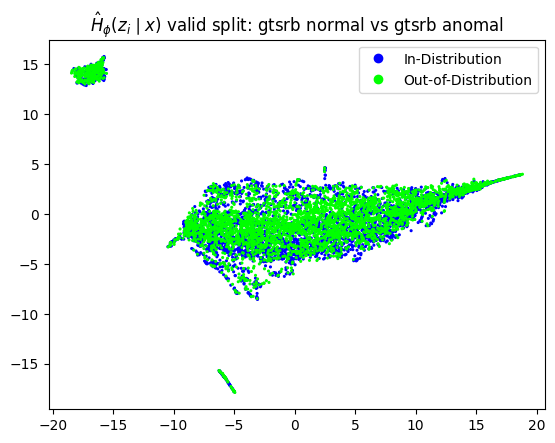

In [18]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid split: gtsrb normal vs gtsrb anomal")

(2546, 128)
(2546, 1)
(2546, 2)


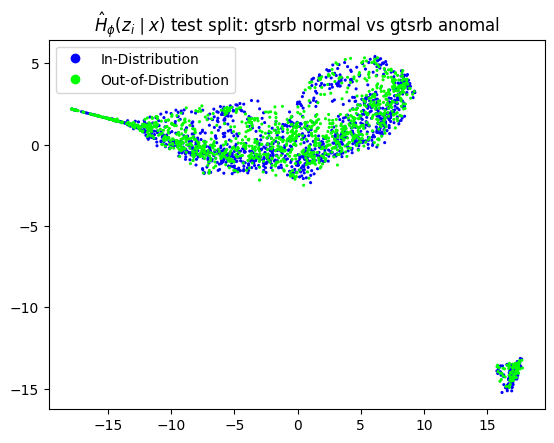

In [16]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np,
                    neighbors=14,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test split: gtsrb normal vs gtsrb anomal")

(13609, 128)
(13609, 1)
(13609, 2)


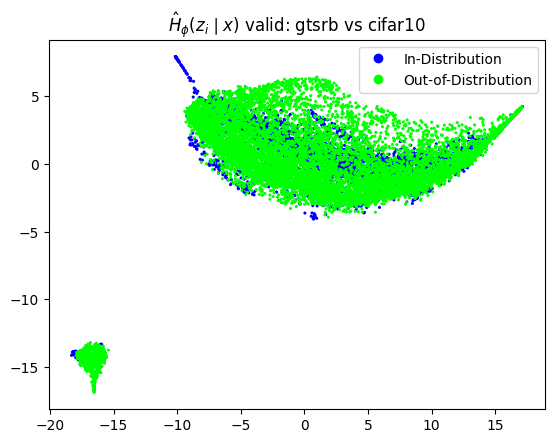

In [20]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    gtsrb_rn18_h_z_cifar10_valid_samples_np,
                    neighbors=14,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs cifar10")

(11273, 128)
(11273, 1)
(11273, 2)


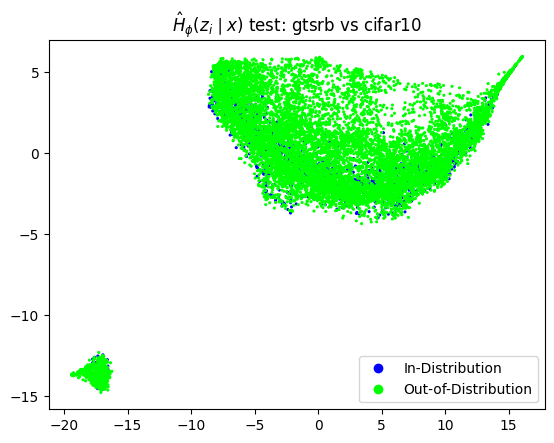

In [19]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    gtsrb_rn18_h_z_cifar10_test_samples_np,
                    neighbors=14,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs cifar10")

(4609, 128)
(4609, 1)
(4609, 2)


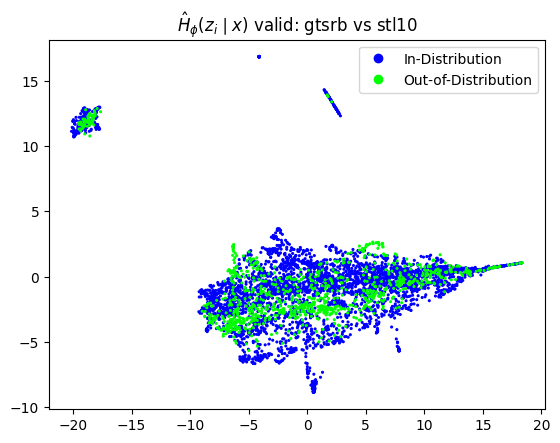

In [21]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    gtsrb_rn18_h_z_stl10_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs stl10")

(9273, 128)
(9273, 1)
(9273, 2)


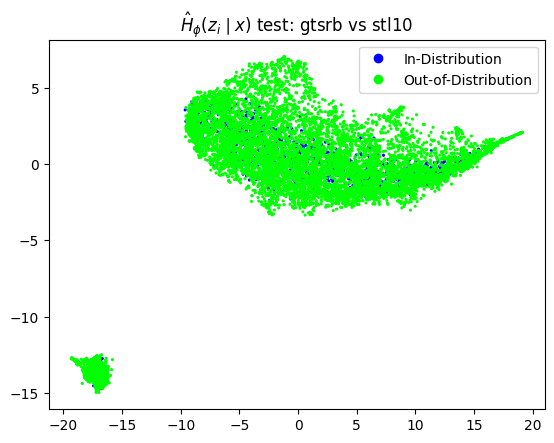

In [22]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    gtsrb_rn18_h_z_stl10_test_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs stl10")